# We will try to guess the MVP for my data mining class term project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import os
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint, uniform
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def save_dataset(df, filename, path='datasets/'):
    """
    Save the DataFrame to a CSV file.
    """
    if not os.path.exists(path):
        os.makedirs(path)
    df.to_csv(os.path.join(path, filename), index=False)
    print(f"Dataset saved to {os.path.join(path, filename)}")

def load_dataset(filename, path='datasets/'):
    """
    Load the DataFrame from a CSV file.
    """
    df = pd.read_csv(os.path.join(path, filename))
    print(f"Dataset loaded from {os.path.join(path, filename)}")
    return df

def explore_missing_data(df):
    """
    Check for missing values and visualize missing data.
    """
    print("Missing Values:")
    missing = df.isnull().sum()
    if (missing > 0).any():
        print(missing[missing > 0])
    msno.matrix(df)
    
def find_missing(df, show_rows=5):
    """
    Print columns with missing values and, sample rows containing them.
    """
    mis = df.isnull().sum()
    mis = mis[mis>0].sort_values(ascending=False)
    if mis.empty:
        print("No missing values!")
    else:
        print("Missing values per column:\n", mis)
        if show_rows>0:
            print(f"\nSample rows with any NaN (up to {show_rows}):")
            print(df[df.isnull().any(axis=1)].head(show_rows))
    
def splitset(df, drop_cols, target_col, test_size=0.2, random_state=39):
    """
    Split the dataset into training and testing sets.
    """
    X = df.drop(columns=drop_cols, errors='ignore')
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    print(f"Training set size: {X_train.shape[0]}, Testing set size: {X_test.shape[0]}")
    return X_train, X_test, y_train, y_test

def build_preprocessor(X, categorical_cols):
    """
    Returns a ColumnTransformer that scales numeric features
    and one‐hot encodes the specified categorical columns.
    """
    # I use StandardScaler and OneHotEncoder for simplicity at least for starting 
    # if they don't work well, I will try different scalers or encoders
    numeric_cols = [c for c in X.columns if c not in categorical_cols]
    return ColumnTransformer([
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ])

def build_lr_pipeline(preprocessor, lr_kwargs=None):
    # Logistic Regression is simple and easy to understand, so I will use it for starting
    if lr_kwargs is None:
        lr_kwargs = dict(max_iter=1000, random_state=39, class_weight='balanced')
    lr = LogisticRegression(**lr_kwargs)
    return Pipeline([
        ('pre', preprocessor),
        ('lr', lr),
    ])
   
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', labels=['Not MVP', 'MVP']):
    """
    Plots a confusion matrix using seaborn's heatmap.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()   
    
def predict_mvp(season_players_df, stage1_pipe, stage2_pipe, threshold=0.3, top_n=10):
    """
    Predicts the MVP from a DataFrame of players for a season.
    
    Args:
        season_players_df: DataFrame with player stats for a season
        threshold: Minimum probability to be considered a candidate
        top_n: Maximum number of candidates to consider
        
    Returns:
        DataFrame with MVP predictions and probabilities
    """
    # Apply Stage 1 model to get candidate probabilities
    X = season_players_df.drop(columns=['player', 'season'], errors='ignore')
    candidate_probs = stage1_pipe.predict_proba(X)[:, 1]
    
    # Filter candidates based on threshold which is 0.3 by default
    candidates_idx = np.where(candidate_probs >= threshold)[0]
    if len(candidates_idx) == 0:
        candidates_idx = np.argsort(candidate_probs)[-top_n:]
        
    candidates = season_players_df.iloc[candidates_idx].copy()
    candidates['candidate_prob'] = candidate_probs[candidates_idx]
    
    # If only one candidate, they're the MVP
    if len(candidates) == 1:
        candidates['mvp_prob'] = 1.0
        return candidates
    
    # Apply Stage 2 model to get MVP probabilities
    X_candidates = candidates.drop(columns=['player', 'season', 'candidate_prob'], errors='ignore')
    mvp_probs = stage2_pipe.predict_proba(X_candidates)[:, 1]
    candidates['mvp_prob'] = mvp_probs
    
    # Sort by MVP probability (highest first)
    return candidates.sort_values('mvp_prob', ascending=False).reset_index(drop=True)


In [4]:
per_100_pos_stats = load_dataset('Per 100 Poss.csv')

Dataset loaded from datasets/Per 100 Poss.csv


In [6]:
for col in per_100_pos_stats.columns:
    print(f"{col}: {per_100_pos_stats[col].dtype}")

seas_id: float64
season: int64
player_id: float64
player: object
birth_year: float64
pos: object
age: int64
experience: float64
lg: object
tm: object
g: int64
gs: float64
mp: int64
fg_per_100_poss: float64
fga_per_100_poss: float64
fg_percent: float64
x3p_per_100_poss: float64
x3pa_per_100_poss: float64
x3p_percent: float64
x2p_per_100_poss: float64
x2pa_per_100_poss: float64
x2p_percent: float64
ft_per_100_poss: float64
fta_per_100_poss: float64
ft_percent: float64
orb_per_100_poss: float64
drb_per_100_poss: float64
trb_per_100_poss: float64
ast_per_100_poss: float64
stl_per_100_poss: float64
blk_per_100_poss: float64
tov_per_100_poss: float64
pf_per_100_poss: float64
pts_per_100_poss: float64
o_rtg: float64
d_rtg: float64


- seas_id (float64): Unique identifier for the season.
- season (int64): The year of the NBA season.
- player_id (float64): Unique identifier for the player.
- player (object): Name of the player.
- birth_year (float64): The birth year of the player.
- pos (object): Player's position.
- age (int64): Player's age during the season.
- experience (float64): Number of years the player has been in the league.
- lg (object): League abbreviation (e.g., NBA).
- tm (object): Team abbreviation (e.g., LAL for Los Angeles Lakers).
- g (int64): Number of games played.
- gs (float64): Number of games started.
- mp (int64): Total minutes played.
- fg_per_100_poss (float64): Field goals made per 100 possessions.
- fga_per_100_poss (float64): Field goal attempts per 100 possessions.
- fg_percent (float64): Field goal percentage.
- x3p_per_100_poss (float64): Three-point field goals made per 100 possessions.
- x3pa_per_100_poss (float64): Three-point field goal attempts per 100 possessions.
- x3p_percent (float64): Three-point field goal percentage.
- x2p_per_100_poss (float64): Two-point field goals made per 100 possessions.
- x2pa_per_100_poss (float64): Two-point field goal attempts per 100 possessions.
- x2p_percent (float64): Two-point field goal percentage.
- ft_per_100_poss (float64): Free throws made per 100 possessions.
- fta_per_100_poss (float64): Free throw attempts per 100 possessions.
- ft_percent (float64): Free throw percentage.
- orb_per_100_poss (float64): Offensive rebounds per 100 possessions.
- drb_per_100_poss (float64): Defensive rebounds per 100 possessions.
- trb_per_100_poss (float64): Total rebounds per 100 possessions.
- ast_per_100_poss (float64): Assists per 100 possessions.
- stl_per_100_poss (float64): Steals per 100 possessions.
- blk_per_100_poss (float64): Blocks per 100 possessions.
- tov_per_100_poss (float64): Turnovers per 100 possessions.
- pf_per_100_poss (float64): Personal fouls per 100 possessions.
- pts_per_100_poss (float64): Points scored per 100 possessions.
- o_rtg (float64): Offensive rating (points produced per 100 possessions).
- d_rtg (float64): Defensive rating (points allowed per 100 possessions).

In [10]:
# I'll only keep the data after 1982, as the NBA changed the way they calculated stats in 1982.
per_100_pos_stats = per_100_pos_stats[per_100_pos_stats['season'] > 1982]
per_100_pos_stats.reset_index(drop=True, inplace=True)
per_100_pos_stats

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
0,31871.0,2025,5025.0,A.J. Green,NaN,SG,25,3.0,NBA,MIL,...,4.3,4.8,3.1,1.2,0.2,1.2,4.7,15.7,118.0,117.0
1,31872.0,2025,5026.0,A.J. Lawson,NaN,SG,24,3.0,NBA,TOR,...,6.5,8.4,2.3,0.9,0.6,1.2,4.3,21.7,106.0,117.0
2,31873.0,2025,5210.0,AJ Johnson,NaN,SG,20,1.0,NBA,TOT,...,4.4,5.3,6.2,1.1,0.2,2.8,2.4,16.9,103.0,122.0
3,31874.0,2025,5210.0,AJ Johnson,NaN,SG,20,1.0,NBA,MIL,...,7.7,7.7,7.7,1.1,0.0,4.4,0.0,22.0,95.0,115.0
4,31875.0,2025,5210.0,AJ Johnson,NaN,SG,20,1.0,NBA,WAS,...,4.0,5.0,6.0,1.1,0.3,2.6,2.7,16.2,104.0,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23501,9470.0,1983,1842.0,Wayne Cooper,NaN,C,26,5.0,NBA,POR,...,9.0,13.8,2.6,0.6,3.1,3.7,7.2,17.6,97.0,102.0
23502,9471.0,1983,1974.0,Wes Matthews,NaN,PG,23,3.0,NBA,ATL,...,2.7,3.7,10.2,2.5,0.3,5.0,5.3,18.1,93.0,105.0
23503,9472.0,1983,1691.0,World B. Free,NaN,SG,29,8.0,NBA,TOT,...,2.0,3.7,5.3,1.8,0.3,3.8,4.4,31.9,106.0,110.0
23504,9473.0,1983,1691.0,World B. Free,NaN,SG,29,8.0,NBA,GSW,...,1.5,2.9,5.9,1.0,0.2,3.3,4.4,28.6,106.0,113.0


In [11]:
# I have combined the players when they played for more than one team in a season.
# Because the MVP is awarded for the whole season, not specific time periods.
weight_col = 'mp'

def weighted_avg(series):
    w = per_100_pos_stats.loc[series.index, weight_col]
    return np.average(series, weights=w) if w.sum() > 0 else series.mean()

rate_cols = [c for c in per_100_pos_stats.select_dtypes('number').columns
             if c not in ['season','g',weight_col]]

agg = {'g':'sum', weight_col:'sum'}
for c in rate_cols:
    agg[c] = weighted_avg

per_100_pos_stats = (
    per_100_pos_stats
      .groupby(['player','season'], as_index=False)
      .agg(agg)
)

In [15]:
# Simple test to check if we combined the players correctly or not.
orig = pd.read_csv('datasets/Per 100 Poss.csv')
orig = orig[orig['season'] > 1982]
before = orig.groupby(['player','season'])[weight_col].sum().sort_index()
after  = per_100_pos_stats.set_index(['player','season'])[weight_col]
differences = pd.testing.assert_series_equal(before, after)
if(differences is None):
    print("The two dataframes are equal!")
else:
    print("The two dataframes are NOT equal!")
    print("Differences:")
    print(after[~after.index.isin(before.index)])
    print(before[~before.index.isin(after.index)])
    print(after[after != before])

The two dataframes are equal!


In [17]:
# Another test to check if we combined the players correctly or not.
# I will check if the maximum number of rows per player and season is 1.
assert per_100_pos_stats.groupby(['player','season']).size().max() == 1, "Assertion failed: More than one row per player and season."
print("Assertion passed: Each player has only one row per season.")

Assertion passed: Each player has only one row per season.


In [13]:
save_dataset(per_100_pos_stats, 'per_100_pos_stats.csv')

Dataset saved to datasets/per_100_pos_stats.csv


Missing Values:
seas_id                 6
player_id               6
experience              2
fg_per_100_poss         5
fga_per_100_poss        5
fg_percent            135
x3p_per_100_poss        5
x3pa_per_100_poss       5
x3p_percent          3009
x2p_per_100_poss        5
x2pa_per_100_poss       5
x2p_percent           222
ft_per_100_poss         5
fta_per_100_poss        5
ft_percent           1019
orb_per_100_poss        5
drb_per_100_poss        5
trb_per_100_poss        5
ast_per_100_poss        5
stl_per_100_poss        5
blk_per_100_poss        5
tov_per_100_poss        5
pf_per_100_poss         5
pts_per_100_poss        5
o_rtg                  77
d_rtg                   5
dtype: int64


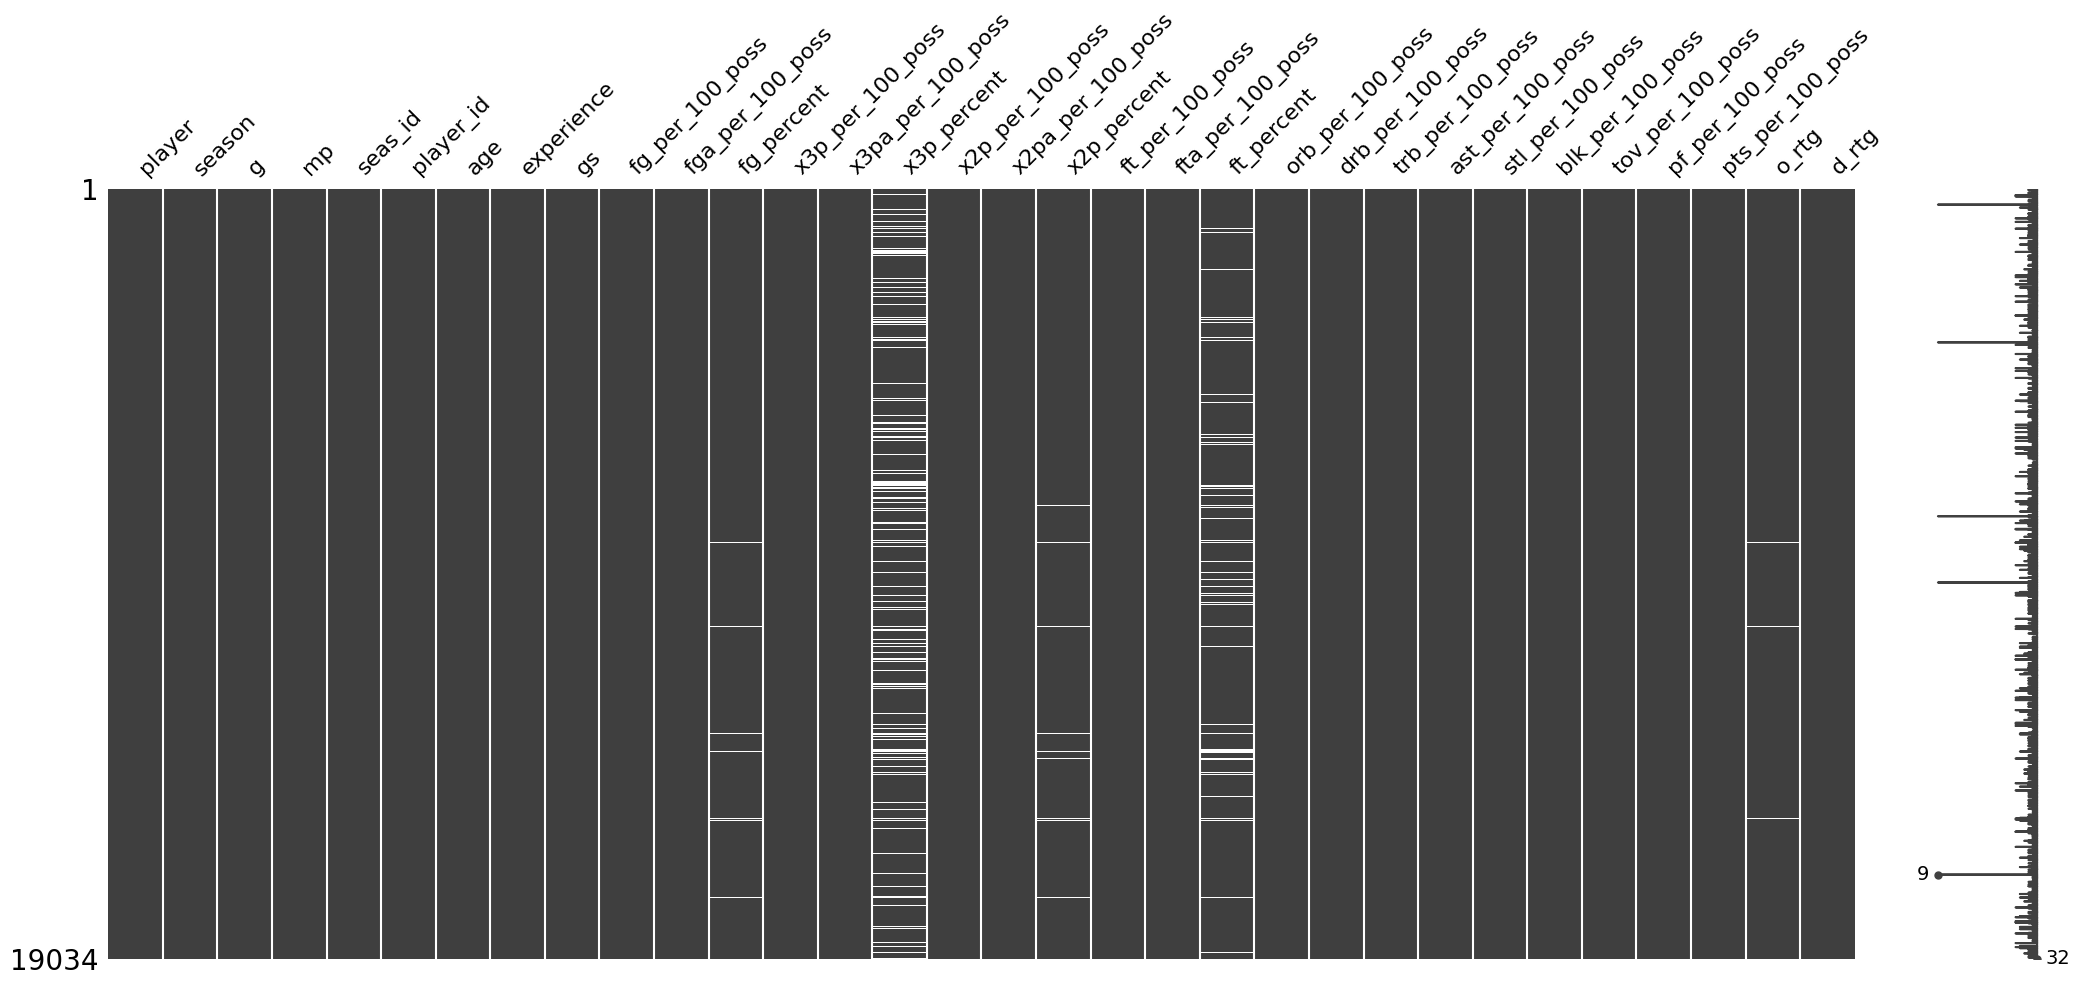

In [18]:
explore_missing_data(per_100_pos_stats)

Missing Values:
player_id               6
experience              2
fg_per_100_poss         5
fga_per_100_poss        5
fg_percent            135
x3p_per_100_poss        5
x3pa_per_100_poss       5
x3p_percent          3009
x2p_per_100_poss        5
x2pa_per_100_poss       5
x2p_percent           222
ft_per_100_poss         5
fta_per_100_poss        5
ft_percent           1019
orb_per_100_poss        5
drb_per_100_poss        5
trb_per_100_poss        5
ast_per_100_poss        5
stl_per_100_poss        5
blk_per_100_poss        5
tov_per_100_poss        5
pf_per_100_poss         5
pts_per_100_poss        5
o_rtg                  77
d_rtg                   5
dtype: int64


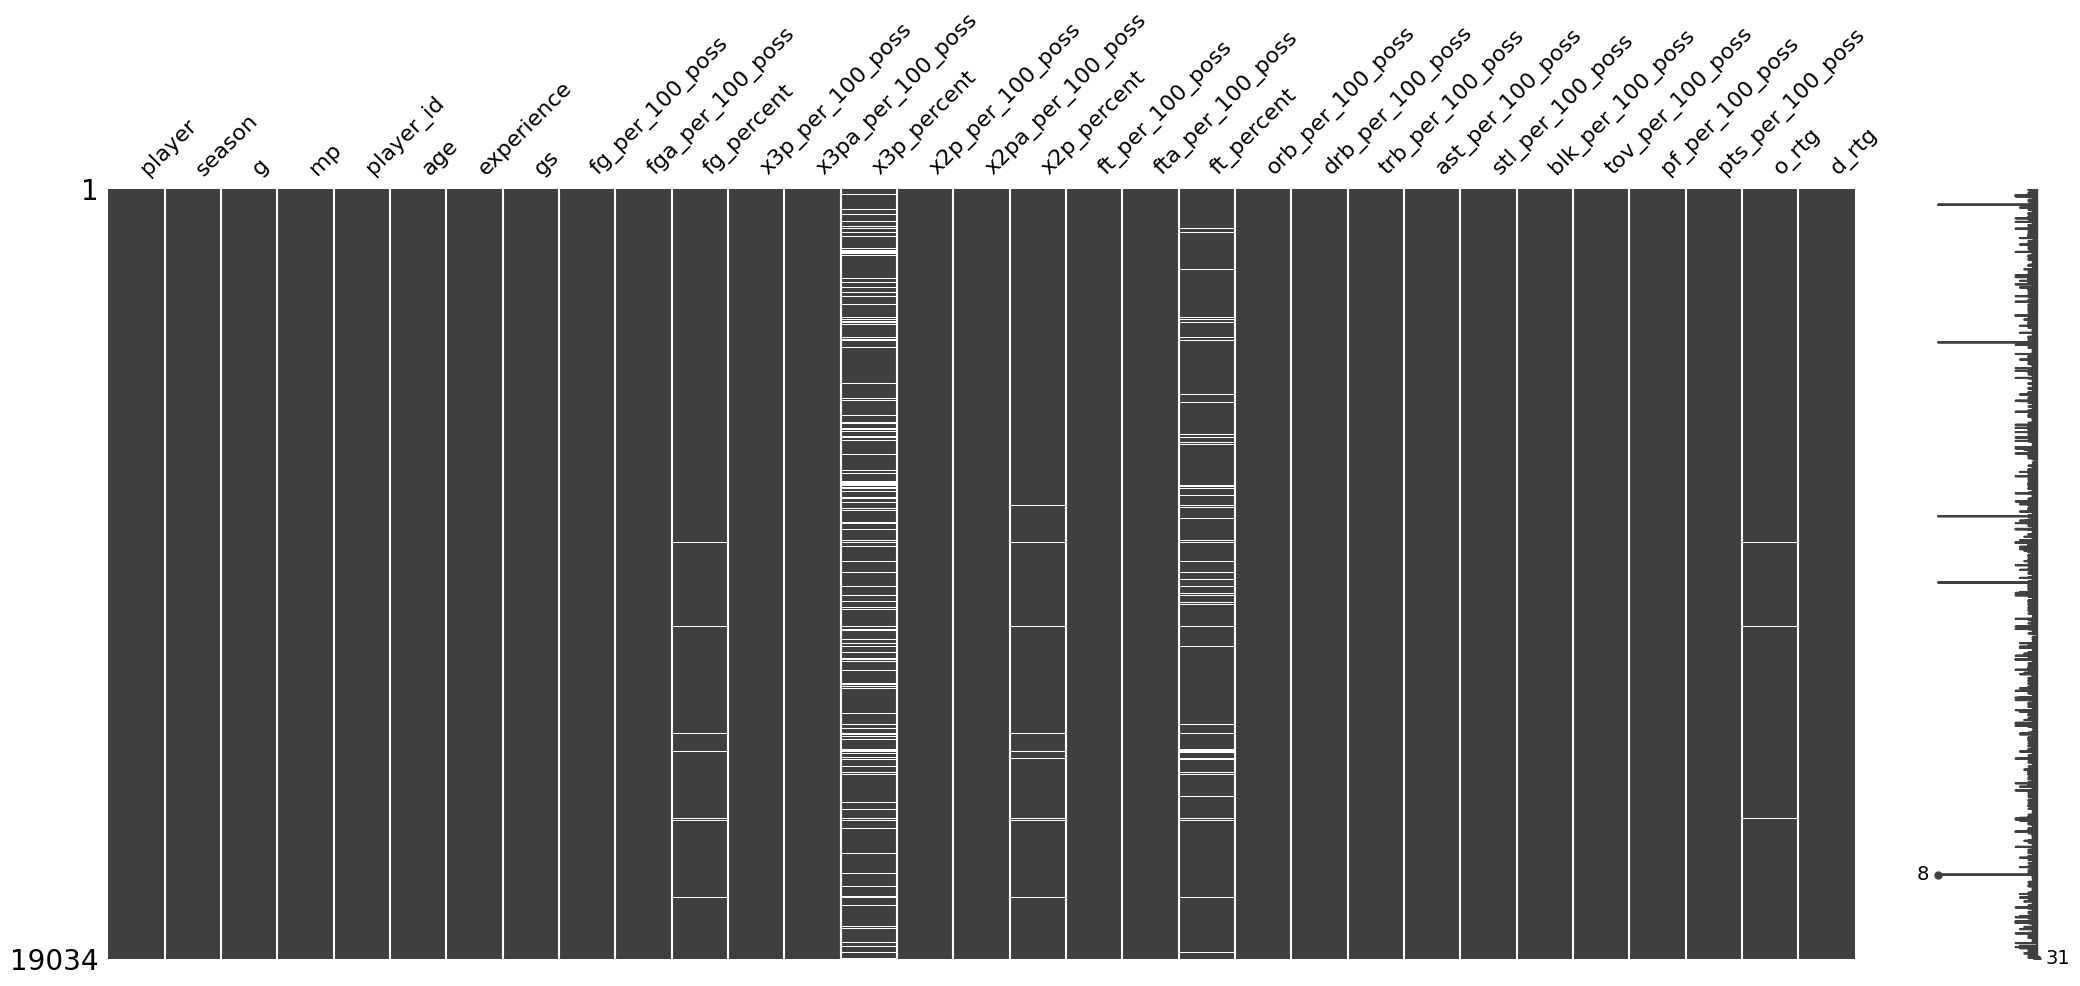

In [ ]:
# I won't keep the seas_id column because 
# it's not useful for the analysis and we combined when players played for multiple teams in one season.
per_100_pos_stats.drop(columns=['seas_id'], inplace=True)
explore_missing_data(per_100_pos_stats)

Missing Values:
fg_per_100_poss         5
fga_per_100_poss        5
fg_percent            135
x3p_per_100_poss        5
x3pa_per_100_poss       5
x3p_percent          3009
x2p_per_100_poss        5
x2pa_per_100_poss       5
x2p_percent           222
ft_per_100_poss         5
fta_per_100_poss        5
ft_percent           1018
orb_per_100_poss        5
drb_per_100_poss        5
trb_per_100_poss        5
ast_per_100_poss        5
stl_per_100_poss        5
blk_per_100_poss        5
tov_per_100_poss        5
pf_per_100_poss         5
pts_per_100_poss        5
o_rtg                  77
d_rtg                   5
dtype: int64


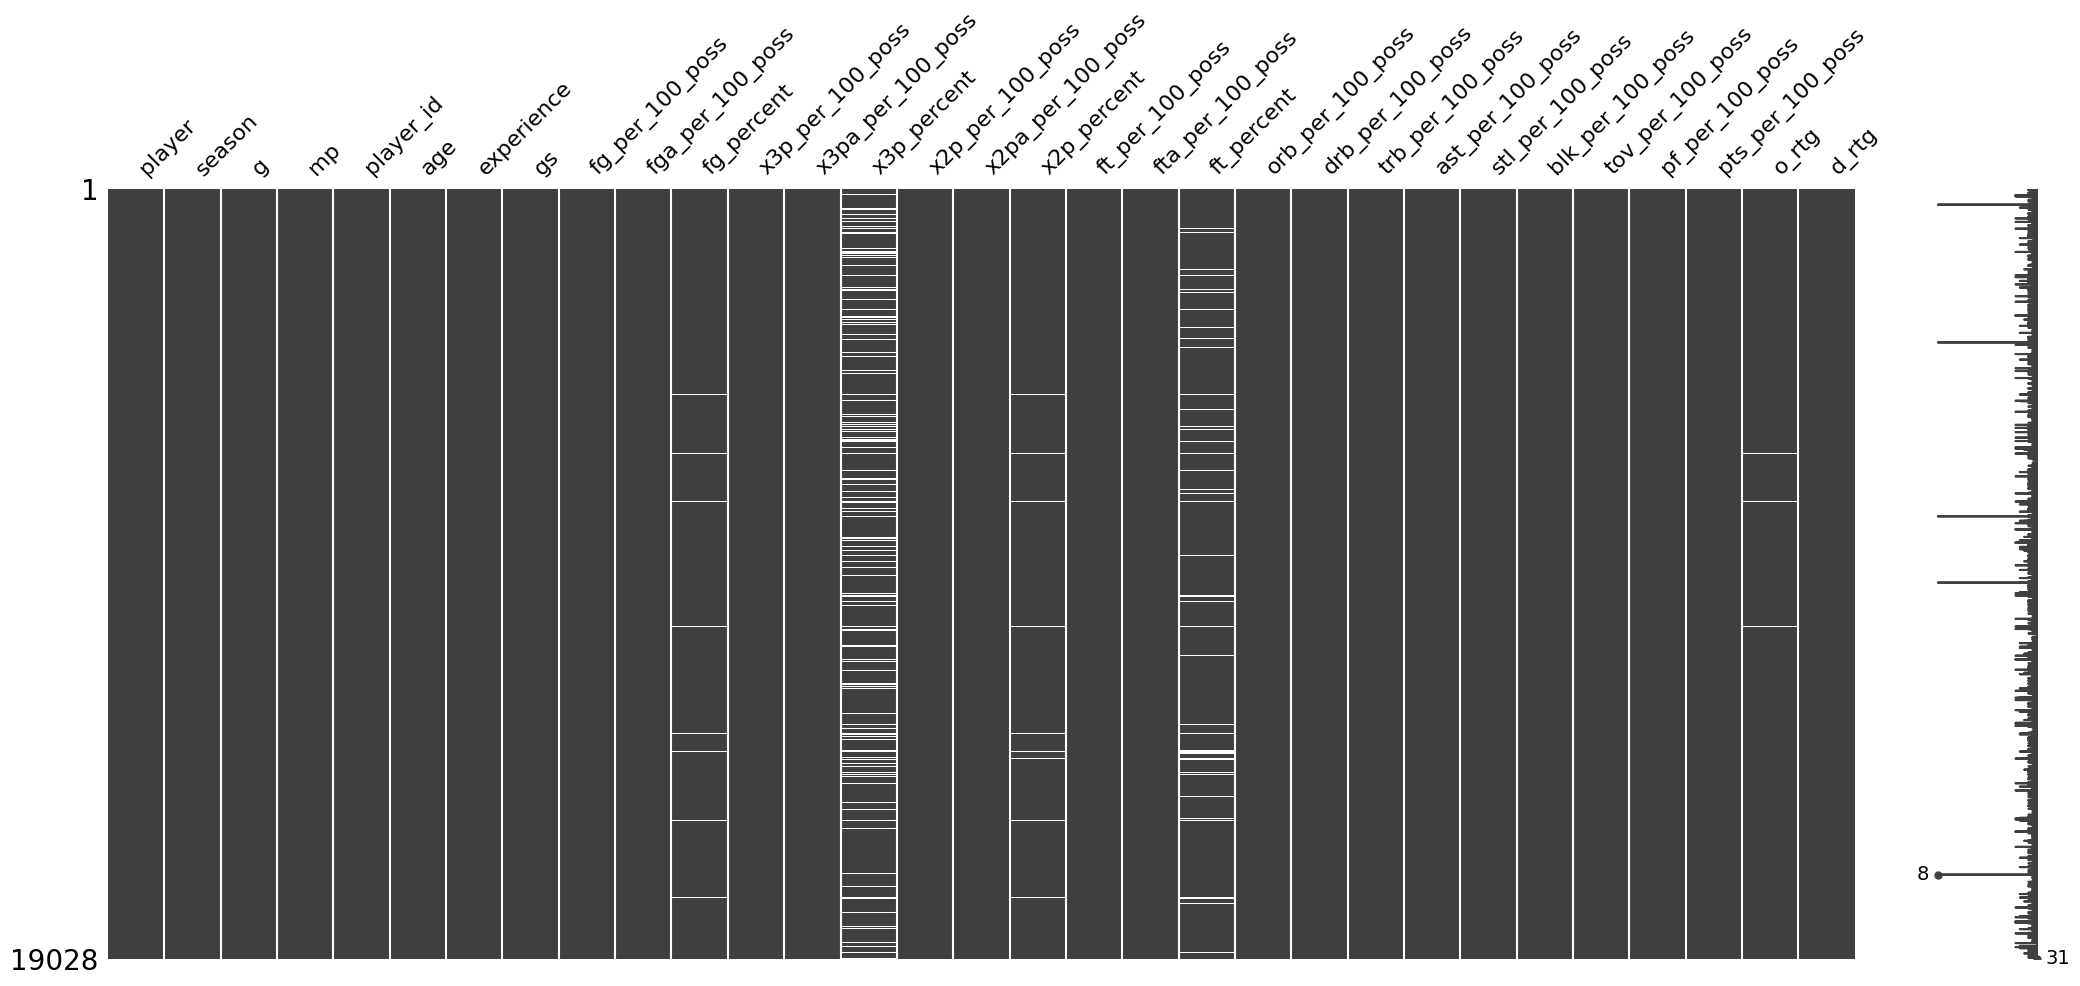

In [ ]:
# In the player_id column, I drop the rows with missing values
per_100_pos_stats.dropna(subset=['player_id'], inplace=True)
explore_missing_data(per_100_pos_stats)

In [ ]:
# I'm filling the shooting percentage columns here
# if there's NaN we replace it with made_per_100_poss / attempts_per_100_poss
# if that ratio is still NaN we replace it with 0
# that means the player didn't attempt any shots in that season
per_100_pos_stats['fg_percent'] = per_100_pos_stats['fg_percent'].fillna(
    per_100_pos_stats['fg_per_100_poss'] / per_100_pos_stats['fga_per_100_poss']
).fillna(0)
per_100_pos_stats['x3p_percent'] = per_100_pos_stats['x3p_percent'].fillna(
    per_100_pos_stats['x3p_per_100_poss'] / per_100_pos_stats['x3pa_per_100_poss']
).fillna(0)
per_100_pos_stats['x2p_percent'] = per_100_pos_stats['x2p_percent'].fillna(
    per_100_pos_stats['x2p_per_100_poss'] / per_100_pos_stats['x2pa_per_100_poss']
).fillna(0)
per_100_pos_stats['ft_percent'] = per_100_pos_stats['ft_percent'].fillna(
    per_100_pos_stats['ft_per_100_poss'] / per_100_pos_stats['fta_per_100_poss']
).fillna(0)

In [18]:
per100_cols = [c for c in per_100_pos_stats.columns if c.endswith('_per_100_poss')]
print(f"Columns with '_per_100_poss': {per100_cols}")

Columns with '_per_100_poss': ['fg_per_100_poss', 'fga_per_100_poss', 'x3p_per_100_poss', 'x3pa_per_100_poss', 'x2p_per_100_poss', 'x2pa_per_100_poss', 'ft_per_100_poss', 'fta_per_100_poss', 'orb_per_100_poss', 'drb_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss', 'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss', 'pf_per_100_poss', 'pts_per_100_poss']


In [ ]:
# I fill the per 100 possessions columns with 0,
# I already filled the shooting percentage columns separately above, so I'll deal with the rest of the columns here.
per_100_pos_stats[per100_cols] = per_100_pos_stats[per100_cols].fillna(0)

In [ ]:
# Offensive and defensive rating columns are filled with the median of the season because,
# If we filled missing values with 0 we would be saying 
# "this player scored 0 points per 100 possessions" or "allowed 0 points"
# which is not likely and would throw off our model.
per_100_pos_stats['o_rtg'] = per_100_pos_stats.groupby('season')['o_rtg'] \
    .transform(lambda x: x.fillna(x.median()))
per_100_pos_stats['d_rtg'] = per_100_pos_stats.groupby('season')['d_rtg'] \
    .transform(lambda x: x.fillna(x.median()))

Missing Values:


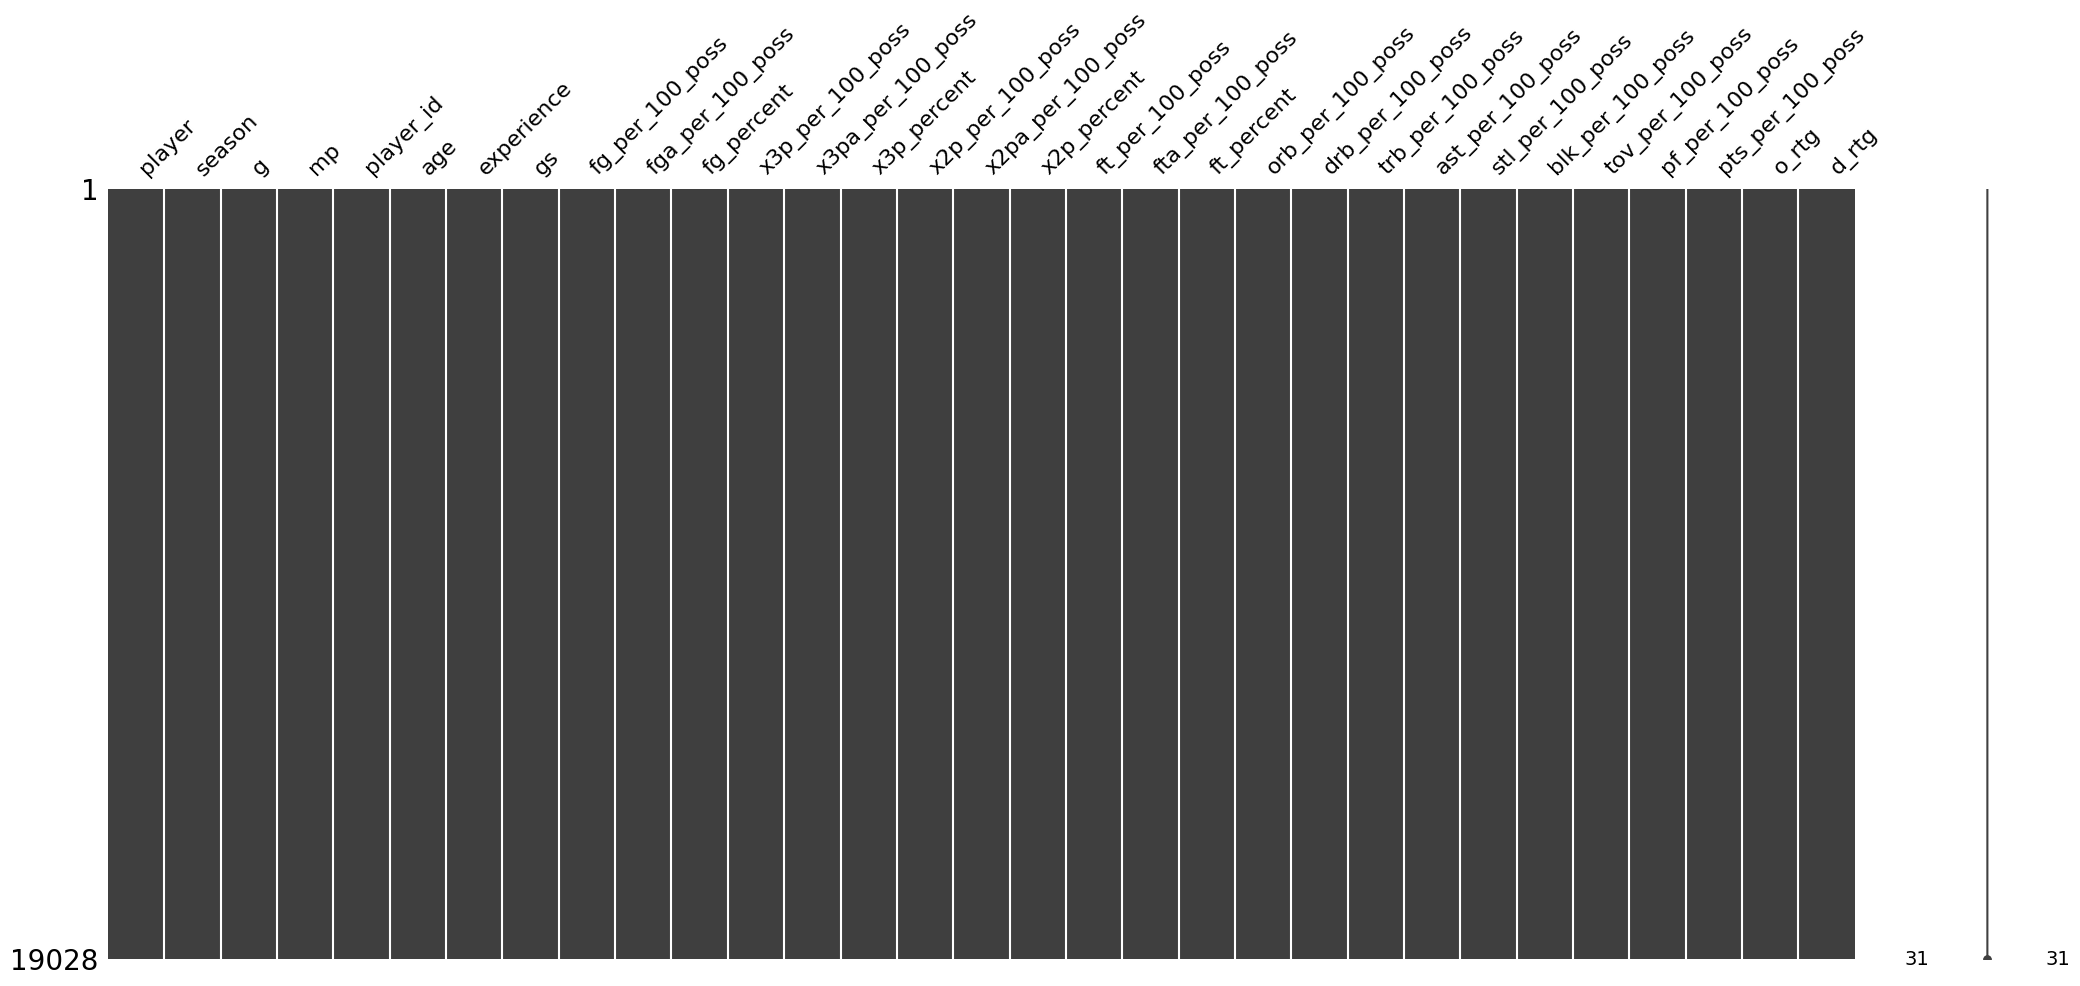

In [25]:
explore_missing_data(per_100_pos_stats)

Great, we have dealt with missing values so far.

In [26]:
save_dataset(per_100_pos_stats, 'per_100_pos_stats.csv')

Dataset saved to datasets/per_100_pos_stats.csv


In [33]:
advanced_stats_df = load_dataset('Advanced.csv')
per_100_pos_stats = load_dataset('per_100_pos_stats.csv')

Dataset loaded from datasets/Advanced.csv
Dataset loaded from datasets/per_100_pos_stats.csv


In [36]:
advanced_stats_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32589 entries, 0 to 32588
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seas_id      32583 non-null  float64
 1   season       32589 non-null  int64  
 2   player_id    32583 non-null  float64
 3   player       32589 non-null  object 
 4   birth_year   2872 non-null   float64
 5   pos          32587 non-null  object 
 6   age          32567 non-null  float64
 7   experience   32587 non-null  float64
 8   lg           32589 non-null  object 
 9   tm           32589 non-null  object 
 10  g            32589 non-null  int64  
 11  mp           31506 non-null  float64
 12  per          31489 non-null  float64
 13  ts_percent   32444 non-null  float64
 14  x3p_ar       26090 non-null  float64
 15  f_tr         32423 non-null  float64
 16  orb_percent  27291 non-null  float64
 17  drb_percent  27291 non-null  float64
 18  trb_percent  28880 non-null  float64
 19  ast_

- per (float64): Player Efficiency Rating, a per-minute rating of a player's performance.
- ts_percent (float64): True Shooting Percentage, a measure of shooting efficiency.
- x3p_ar (float64): Three-Point Attempt Rate, the ratio of three-point attempts to total field goal attempts.
- f_tr (float64): Free Throw Rate, the ratio of free throw attempts to field goal attempts.
- orb_percent (float64): Offensive Rebound Percentage, the percentage of available offensive rebounds a player grabs.
- drb_percent (float64): Defensive Rebound Percentage, the percentage of available defensive rebounds a player grabs.
- trb_percent (float64): Total Rebound Percentage, the percentage of total available rebounds a player grabs.
- ast_percent (float64): Assist Percentage, the percentage of teammate field goals a player assisted while on the court.
- stl_percent (float64): Steal Percentage, the percentage of opponent possessions that end in a steal by the player.
- blk_percent (float64): Block Percentage, the percentage of opponent two-point field goal attempts blocked by the player.
- tov_percent (float64): Turnover Percentage, the percentage of a player's possessions that end in a turnover.
- usg_percent (float64): Usage Percentage, the percentage of team plays used by the player while on the court.
- ows (float64): Offensive Win Shares, an estimate of the number of wins contributed by a player due to their offense.
- dws (float64): Defensive Win Shares, an estimate of the number of wins contributed by a player due to their defense.
- ws (float64): Win Shares, the total number of wins contributed by a player.
- ws_48 (float64): Win Shares Per 48 Minutes, an estimate of wins contributed per 48 minutes played.
- obpm (float64): Offensive Box Plus/Minus, a box score estimate of the offensive points per 100 possessions a player contributes above a league-average player.
- dbpm (float64): Defensive Box Plus/Minus, a box score estimate of the defensive points per 100 possessions a player contributes above a league-average player.
- bpm (float64): Box Plus/Minus, a box score estimate of the total points per 100 possessions a player contributes above a league-average player.
- vorp (float64): Value Over Replacement Player, a box score estimate of a player's overall value compared to a replacement-level player.

In [ ]:
# I'm grabbing some advanced stats columns that I think those can be useful for the model.
adv_cols = [
    'player_id','season',
    'per','ts_percent','usg_percent',
    'ows','dws','ws','ws_48',
    'obpm','dbpm','bpm','vorp',
    'age','experience','pos'
]
adv = advanced_stats_df[adv_cols].drop_duplicates(['player_id','season'])

# I drop those columns because else they will be duplicated in the final dataframe
per_100_pos_stats.drop(columns=['age','experience'], inplace=True)

# Here merging them into one dataframe.
df = per_100_pos_stats.merge(adv, on=['player_id','season'], how='left')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19028 entries, 0 to 19027
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             19028 non-null  object 
 1   season             19028 non-null  int64  
 2   g                  19028 non-null  int64  
 3   mp                 19028 non-null  int64  
 4   player_id          19028 non-null  float64
 5   gs                 19028 non-null  float64
 6   fg_per_100_poss    19028 non-null  float64
 7   fga_per_100_poss   19028 non-null  float64
 8   fg_percent         19028 non-null  float64
 9   x3p_per_100_poss   19028 non-null  float64
 10  x3pa_per_100_poss  19028 non-null  float64
 11  x3p_percent        19028 non-null  float64
 12  x2p_per_100_poss   19028 non-null  float64
 13  x2pa_per_100_poss  19028 non-null  float64
 14  x2p_percent        19028 non-null  float64
 15  ft_per_100_poss    19028 non-null  float64
 16  fta_per_100_poss   190

In [48]:
print(df[['age','experience']].corr())

X = df[['age','experience']].dropna()
vif = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print(vif)

                 age  experience
age         1.000000    0.895177
experience  0.895177    1.000000
      feature       VIF
0         age  4.347728
1  experience  4.347728


In [ ]:
# Age and experience are highly correlated, so I'll drop age here
df.drop(columns=['age'], inplace=True)

In [50]:
save_dataset(df, 'combined_stats.csv')

Dataset saved to datasets/combined_stats.csv


In [ ]:
corr = df.corr()
high_corr = (
    corr.abs() # we get absolute value of the correlation matrix
        .unstack() # then flattens the square matrix into a series
        .reset_index() # convert the series into a dataframe
        .rename(columns={'level_0':'var1','level_1':'var2',0:'corr'})
)
high_corr = high_corr[
    (high_corr['corr'] > 0.8) & # we filter highly correlated pairs
    (high_corr['var1'] != high_corr['var2']) # we remove self correlations
]
print(
    high_corr
      .sort_values('corr',ascending=False)
      .drop_duplicates(subset=['corr']) # to not take (var1,var2) and (var2,var1) at the same time
)

                   var1               var2      corr
1351                 ws                ows  0.949635
3                season          player_id  0.943968
1515                bpm               obpm  0.941608
225     fg_per_100_poss   pts_per_100_poss  0.935637
1206        usg_percent   fga_per_100_poss  0.931459
575     ft_per_100_poss   fta_per_100_poss  0.925697
1553               vorp                 ws  0.908981
329    x3p_per_100_poss  x3pa_per_100_poss  0.901472
739    drb_per_100_poss   trb_per_100_poss  0.898269
1428               obpm                per  0.891290
1278                ows               vorp  0.888210
1397              ws_48                bpm  0.885269
1154                per              ws_48  0.884725
1069              o_rtg         ts_percent  0.877675
1508                bpm                per  0.872023
211     fg_per_100_poss   x2p_per_100_poss  0.867275
491   x2pa_per_100_poss   x2p_per_100_poss  0.865047
1167         ts_percent         fg_percent  0.

In [ ]:
# I will drop highly correlated columns to avoid multicollinearity.
drop_ws = ['ows','dws','ws','vorp']

drop_bpm = ['obpm','dbpm']

drop_pct = ['fg_percent','x2p_percent','x3p_percent','ft_percent']

drop_rates = ['fga_per_100_poss','fta_per_100_poss','x2pa_per_100_poss','x3pa_per_100_poss']

drop_pts_reb = ['pts_per_100_poss','orb_per_100_poss']

drop_per = ['per']

drop_ids = ['player_id']

# I aggregate all columns to drop into one list
to_drop = drop_ws + drop_bpm + drop_pct + drop_rates + drop_pts_reb + drop_per + drop_ids

df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)
df.head()

,player,season,g,mp,gs,fg_per_100_poss,x3p_per_100_poss,x2p_per_100_poss,ft_per_100_poss,drb_per_100_poss,...,tov_per_100_poss,pf_per_100_poss,o_rtg,d_rtg,ts_percent,usg_percent,ws_48,bpm,experience,pos
0,A.C. Green,1986,82,1542,1.0,6.3,0.0,6.3,3.1,6.7,...,3.0,6.9,108.0,105.0,0.564,14.7,0.103,-1.6,1.0,PF
1,A.C. Green,1987,79,2240,72.0,6.7,0.0,6.7,4.6,8.5,...,2.2,3.6,122.0,105.0,0.599,14.7,0.163,1.0,2.0,PF
2,A.C. Green,1988,82,2636,64.0,5.9,0.0,5.9,5.4,8.5,...,2.2,3.7,119.0,106.0,0.581,14.7,0.144,0.3,3.0,PF
3,A.C. Green,1989,82,2510,82.0,7.7,0.1,7.6,5.4,9.2,...,2.3,3.3,122.0,105.0,0.594,17.0,0.179,1.6,4.0,PF
4,A.C. Green,1990,82,2709,82.0,7.1,0.2,6.8,5.1,8.3,...,2.1,3.8,116.0,107.0,0.548,17.1,0.137,-0.6,5.0,PF


In [76]:
save_dataset(df, 'combined_stats_dropped.csv')

Dataset saved to datasets/combined_stats_dropped.csv


In [ ]:
# I need this dataset for to get data of past MVPs
mvp_df = load_dataset('Player Award Shares.csv')
mvp_df = mvp_df[mvp_df['season'] > 1982]
mvp_df = mvp_df[mvp_df['award'] == 'nba mvp']
mvp_df

Dataset loaded from datasets/Player Award Shares.csv


,season,award,player,age,tm,first,pts_won,pts_max,share,winner,seas_id,player_id
42,2024,nba mvp,Nikola Jokić,28,DEN,79.0,926.0,990.0,0.935,True,31672,4352
43,2024,nba mvp,Shai Gilgeous-Alexander,25,OKC,15.0,640.0,990.0,0.646,False,31769,4670
44,2024,nba mvp,Luka Dončić,24,DAL,4.0,566.0,990.0,0.572,False,31593,4654
45,2024,nba mvp,Giannis Antetokounmpo,29,MIL,1.0,192.0,990.0,0.194,False,31366,4164
46,2024,nba mvp,Jalen Brunson,27,NYK,0.0,142.0,990.0,0.143,False,31429,4630
...,...,...,...,...,...,...,...,...,...,...,...,...
2810,1983,nba mvp,Gus Williams,29,SEA,0.0,3.0,750.0,0.004,False,9215,1647
2811,1983,nba mvp,Dan Roundfield,29,ATL,0.0,2.0,750.0,0.003,False,9154,1634
2812,1983,nba mvp,Marques Johnson,26,MIL,0.0,1.5,750.0,0.002,False,9330,1767
2813,1983,nba mvp,Norm Nixon,27,LAL,0.0,1.0,750.0,0.001,False,9357,1770


In [ ]:
# retrieve the MVP winner data for each season into our main data set.
df = df.merge(
    mvp_df[['player','season','winner']],
    on=['player','season'],
    how='left'
)

,player,season,g,mp,gs,fg_per_100_poss,x3p_per_100_poss,x2p_per_100_poss,ft_per_100_poss,drb_per_100_poss,...,pf_per_100_poss,o_rtg,d_rtg,ts_percent,usg_percent,ws_48,bpm,experience,pos,winner
0,A.C. Green,1986,82,1542,1.000000,6.300000,0.0,6.300000,3.100000,6.700000,...,6.900000,108.00000,105.000000,0.564,14.7,0.103,-1.6,1.0,PF,NaN
1,A.C. Green,1987,79,2240,72.000000,6.700000,0.0,6.700000,4.600000,8.500000,...,3.600000,122.00000,105.000000,0.599,14.7,0.163,1.0,2.0,PF,NaN
2,A.C. Green,1988,82,2636,64.000000,5.900000,0.0,5.900000,5.400000,8.500000,...,3.700000,119.00000,106.000000,0.581,14.7,0.144,0.3,3.0,PF,NaN
3,A.C. Green,1989,82,2510,82.000000,7.700000,0.1,7.600000,5.400000,9.200000,...,3.300000,122.00000,105.000000,0.594,17.0,0.179,1.6,4.0,PF,NaN
4,A.C. Green,1990,82,2709,82.000000,7.100000,0.2,6.800000,5.100000,8.300000,...,3.800000,116.00000,107.000000,0.548,17.1,0.137,-0.6,5.0,PF,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19023,Željko Rebrača,2002,74,1179,4.000000,8.500000,0.0,8.500000,6.100000,9.300000,...,8.700000,105.00000,100.000000,0.569,21.4,0.134,-2.3,1.0,C,NaN
19024,Željko Rebrača,2003,30,488,12.000000,9.100000,0.0,9.100000,4.300000,7.400000,...,9.000000,107.00000,101.000000,0.596,19.2,0.133,-2.6,2.0,C,NaN
19025,Željko Rebrača,2004,48,546,1.813187,6.753846,0.0,6.753846,4.589011,6.994505,...,10.345055,98.21978,98.307692,0.504,18.2,0.097,-3.9,3.0,C,NaN
19026,Željko Rebrača,2005,58,928,2.000000,7.700000,0.0,7.700000,4.200000,7.800000,...,7.500000,114.00000,106.000000,0.625,16.0,0.122,-1.3,4.0,C,NaN


In [85]:
df.rename(columns={'winner':'is_mvp'}, inplace=True)
df['is_mvp'] = df['is_mvp'].fillna(0).astype(int)
df

,player,season,g,mp,gs,fg_per_100_poss,x3p_per_100_poss,x2p_per_100_poss,ft_per_100_poss,drb_per_100_poss,...,pf_per_100_poss,o_rtg,d_rtg,ts_percent,usg_percent,ws_48,bpm,experience,pos,is_mvp
0,A.C. Green,1986,82,1542,1.000000,6.300000,0.0,6.300000,3.100000,6.700000,...,6.900000,108.00000,105.000000,0.564,14.7,0.103,-1.6,1.0,PF,0
1,A.C. Green,1987,79,2240,72.000000,6.700000,0.0,6.700000,4.600000,8.500000,...,3.600000,122.00000,105.000000,0.599,14.7,0.163,1.0,2.0,PF,0
2,A.C. Green,1988,82,2636,64.000000,5.900000,0.0,5.900000,5.400000,8.500000,...,3.700000,119.00000,106.000000,0.581,14.7,0.144,0.3,3.0,PF,0
3,A.C. Green,1989,82,2510,82.000000,7.700000,0.1,7.600000,5.400000,9.200000,...,3.300000,122.00000,105.000000,0.594,17.0,0.179,1.6,4.0,PF,0
4,A.C. Green,1990,82,2709,82.000000,7.100000,0.2,6.800000,5.100000,8.300000,...,3.800000,116.00000,107.000000,0.548,17.1,0.137,-0.6,5.0,PF,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19023,Željko Rebrača,2002,74,1179,4.000000,8.500000,0.0,8.500000,6.100000,9.300000,...,8.700000,105.00000,100.000000,0.569,21.4,0.134,-2.3,1.0,C,0
19024,Željko Rebrača,2003,30,488,12.000000,9.100000,0.0,9.100000,4.300000,7.400000,...,9.000000,107.00000,101.000000,0.596,19.2,0.133,-2.6,2.0,C,0
19025,Željko Rebrača,2004,48,546,1.813187,6.753846,0.0,6.753846,4.589011,6.994505,...,10.345055,98.21978,98.307692,0.504,18.2,0.097,-3.9,3.0,C,0
19026,Željko Rebrača,2005,58,928,2.000000,7.700000,0.0,7.700000,4.200000,7.800000,...,7.500000,114.00000,106.000000,0.625,16.0,0.122,-1.3,4.0,C,0


In [86]:
save_dataset(df, 'combined_stats_final.csv')

Dataset saved to datasets/combined_stats_final.csv


In [119]:
find_missing(df)

Missing values per column:
 ts_percent     88
usg_percent    23
ws_48          23
bpm            20
experience     20
pos            20
dtype: int64

Sample rows with any NaN (up to 5):
               player  season  g  mp   gs  fg_per_100_poss  x3p_per_100_poss  \
149        Ade Murkey    2022  1   1  0.0              0.0               0.0   
183   Adrian Caldwell    1998  1   3  0.0              0.0               0.0   
386       Alex Scales    2006  1   0  0.0              0.0               0.0   
459  Alondes Williams    2023  1   5  0.0              0.0               0.0   
813        Andy Panko    2001  1   1  0.0              0.0               0.0   

     x2p_per_100_poss  ft_per_100_poss  drb_per_100_poss  ...  \
149               0.0              0.0               0.0  ...   
183               0.0              0.0               0.0  ...   
386               0.0              0.0               0.0  ...   
459               0.0              0.0               9.8  ...   
813     

In [ ]:
# I use median over mean to get less affected by outliers which is common in sports data.
num_cols = ['ts_percent','usg_percent','ws_48','bpm','experience']
for c in num_cols:
    df[c] = df.groupby('season')[c] \
             .transform(lambda x: x.fillna(x.median()))
df['pos'] = df['pos'].fillna('Unknown')

In [121]:
find_missing(df)

No missing values!


In [122]:
save_dataset(df, 'combined_stats_final.csv')

Dataset saved to datasets/combined_stats_final.csv


In [4]:
# I also drop 'player' and 'season' from the training set because they are not useful for the model.
# I don't want the model to learn from these columns, they are just identifiers.
X_train, X_test, y_train, y_test = splitset(df,['is_mvp','player','season'],'is_mvp', test_size=0.2, random_state=39)

Training set size: 15222, Testing set size: 3806


In [5]:
# We're just scaling the numeric columns with standard scaler and one-hot encoding the categorical columns which is only 'pos'.
pre = build_preprocessor(X_train, ['pos'])

In [6]:
# I'll start with logistic regression, as it is a simple model
lr_pipe = build_lr_pipeline(pre)
print("LR CV F1:", cross_val_score(lr_pipe, X_train, y_train, cv=5, scoring='f1').mean())

LR CV F1: 0.22096914335578538


              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3798
           1       0.12      1.00      0.22         8

    accuracy                           0.99      3806
   macro avg       0.56      0.99      0.61      3806
weighted avg       1.00      0.99      0.99      3806

[[3742   56]
 [   0    8]]


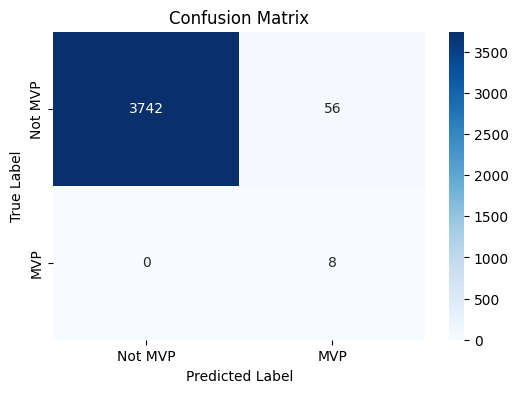

In [7]:
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# We're pretty good at predicting not MVPs but this is not because of the model,
# it's because the dataset is highly imbalanced.
# we have 3742 true negatives and 56 false positives (non MVPs predicted as MVPs)
# In imbalanced datasets, the model tends to predict the majority class more often.
# So we can try changing default decision threshold of 0.5 to different values.

Threshold 0.5
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3798
           1       0.12      1.00      0.22         8

    accuracy                           0.99      3806
   macro avg       0.56      0.99      0.61      3806
weighted avg       1.00      0.99      0.99      3806

[[3742   56]
 [   0    8]]



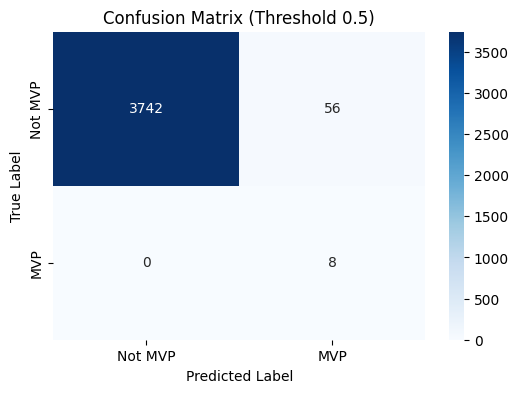

Threshold 0.6
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3798
           1       0.13      0.88      0.23         8

    accuracy                           0.99      3806
   macro avg       0.56      0.93      0.61      3806
weighted avg       1.00      0.99      0.99      3806

[[3751   47]
 [   1    7]]



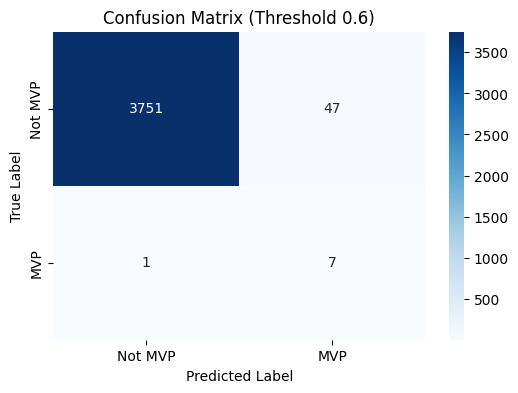

Threshold 0.7
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3798
           1       0.15      0.88      0.25         8

    accuracy                           0.99      3806
   macro avg       0.57      0.93      0.62      3806
weighted avg       1.00      0.99      0.99      3806

[[3757   41]
 [   1    7]]



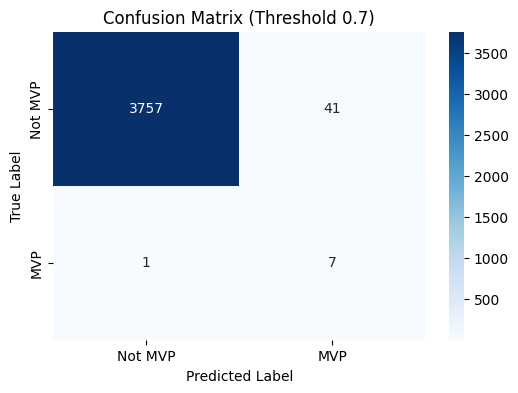

Threshold 0.8
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3798
           1       0.17      0.88      0.28         8

    accuracy                           0.99      3806
   macro avg       0.58      0.93      0.64      3806
weighted avg       1.00      0.99      0.99      3806

[[3763   35]
 [   1    7]]



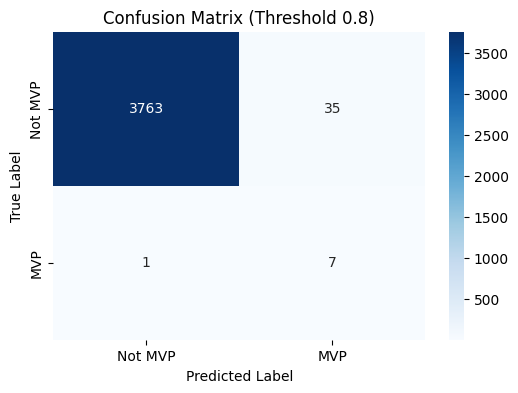

In [8]:
y_proba = lr_pipe.predict_proba(X_test)[:,1]
for thresh in [0.5, 0.6, 0.7, 0.8]:
    y_pred_t = (y_proba >= thresh).astype(int)
    print(f"Threshold {thresh}")
    print(classification_report(y_test, y_pred_t))
    print(confusion_matrix(y_test, y_pred_t), end='\n\n')
    plot_confusion_matrix(y_test, y_pred_t, title=f"Confusion Matrix (Threshold {thresh})")

In higher thresholds we get less false positives but we missed one real MVP. Although in overall we increased f1 score a bit

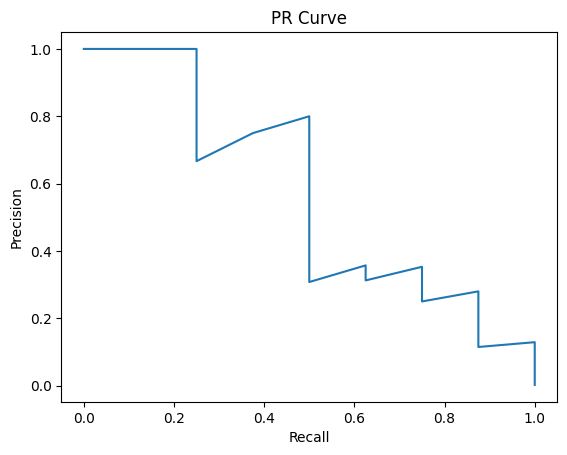

In [129]:
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve')
plt.show()

Well as I expected logistic regression model won't do it, especially f1 score is pretty low and we have too many false positives.

RF CV F1: 0.36507936507936506
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3798
           1       0.33      0.88      0.48         8

    accuracy                           1.00      3806
   macro avg       0.67      0.94      0.74      3806
weighted avg       1.00      1.00      1.00      3806

[[3784   14]
 [   1    7]]


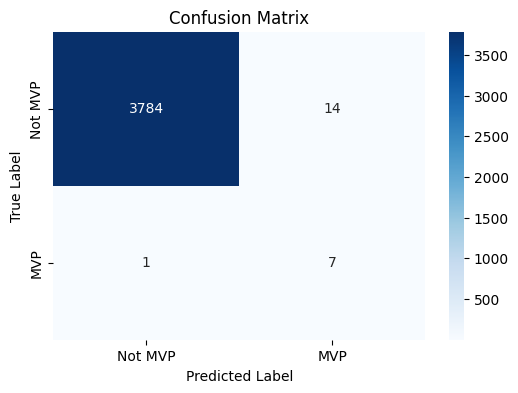

In [10]:
rf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=39
)

rf_pipe = Pipeline([
    ('pre', pre),
    ('rf', rf)
])

print("RF CV F1:", cross_val_score(rf_pipe, X_train, y_train, cv=5, scoring='f1').mean())

rf_pipe.fit(X_train, y_train)
rf_pred = rf_pipe.predict(X_test)
print(classification_report(y_test, rf_pred))
print(confusion_matrix(y_test, rf_pred))
plot_confusion_matrix(y_test, rf_pred)

Looking far more promising than previous attempt

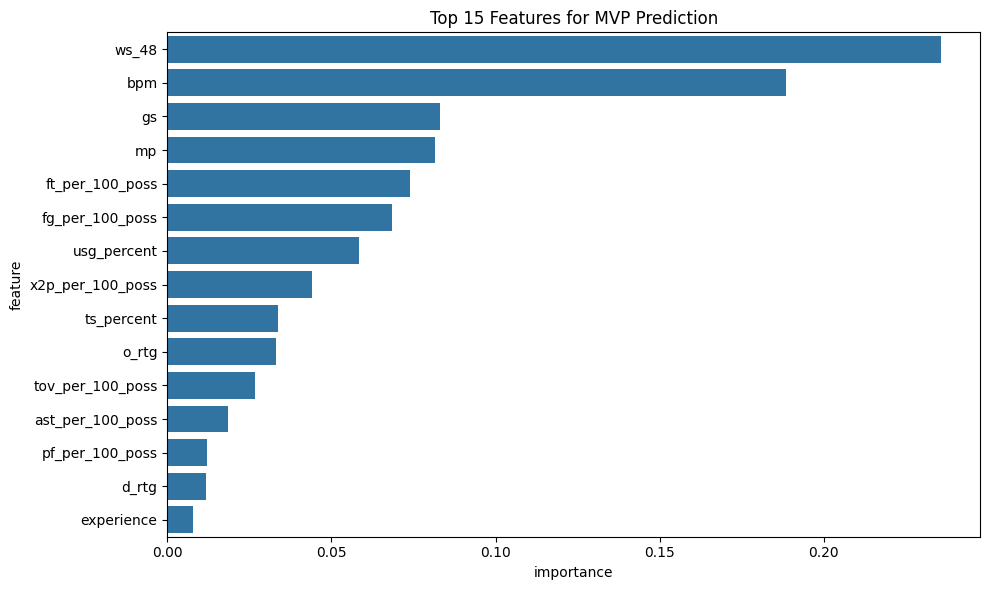

In [131]:
feature_names = (
    pre.named_transformers_['num'].get_feature_names_out().tolist() +
    pre.named_transformers_['cat'].get_feature_names_out().tolist()
)

importances = rf_pipe.named_steps['rf'].feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Top 15 Features for MVP Prediction')
plt.tight_layout()
plt.show()

ws_48 (Win Shares per 48 minutes) and bpm (Box Plus/Minus) are by far the most influential. This means players with high values in these advanced metrics are much more likely to be predicted as MVPs.

gs (Games Started) and mp (Minutes Played) are also important, indicating that playing time and being a starter are strong signals for MVP candidacy.
ft_per_100_poss and fg_per_100_poss (Free Throws and Field Goals per 100 possessions) show that scoring efficiency and volume matter.

usg_percent (Usage Percentage) and ts_percent (True Shooting Percentage) highlight the importance of a player’s offensive role and efficiency.

o_rtg (Offensive Rating) and d_rtg (Defensive Rating) suggest that both offensive and defensive contributions are considered by the model.

Experience: While present, experience is less important, suggesting that MVPs can be both veterans and younger stars. (Just like D. Rose)

In [ ]:
misclassified_idx = (rf_pred != y_test) & (y_test == 1)
missed_mvps = df.iloc[y_test[misclassified_idx].index]
print("Missed MVPs:", missed_mvps[['player', 'season']])

Missed MVPs:             player  season
10100  Karl Malone    1999


In [133]:
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=100,
    random_state=39
)

xgb_pipe = Pipeline([
    ('pre', pre),
    ('xgb', xgb_clf)
])

print("XGB CV F1:", cross_val_score(xgb_pipe, X_train, y_train, cv=5, scoring='f1').mean())

XGB CV F1: 0.33959383753501393


In [ ]:
# I'll try hyperparameter tuning with RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': randint(100, 500),
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.3),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__gamma': uniform(0, 1),
    'xgb__min_child_weight': randint(1, 10),
    'xgb__scale_pos_weight': [50, 75, 100, 150, 200] 
}

xgb_base = Pipeline([
    ('pre', pre),
    ('xgb', XGBClassifier(random_state=39))
])

xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='f1',
    random_state=39,
    n_jobs=-1,
    verbose=2
)

xgb_search.fit(X_train, y_train)

print("Best parameters:", xgb_search.best_params_)
print("Best CV F1 score:", xgb_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'xgb__colsample_bytree': np.float64(0.7548775059853394), 'xgb__gamma': np.float64(0.1743128454402857), 'xgb__learning_rate': np.float64(0.18018938320202518), 'xgb__max_depth': 9, 'xgb__min_child_weight': 7, 'xgb__n_estimators': 403, 'xgb__scale_pos_weight': 50, 'xgb__subsample': np.float64(0.8706026665344591)}
Best CV F1 score: 0.47333333333333333


We used XGBoost with hyperparameter tuning. The initial mean F1 score was 0.34, which improved to 0.47 after tuning. This demonstrates the importance of model optimization, especially for imbalanced datasets. While the model shows decent predictive power, further improvements could be explored to increase accuracy. After all F1 score is still below 0.5

Test set performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3798
           1       0.43      0.38      0.40         8

    accuracy                           1.00      3806
   macro avg       0.71      0.69      0.70      3806
weighted avg       1.00      1.00      1.00      3806

Confusion matrix:
[[3794    4]
 [   5    3]]


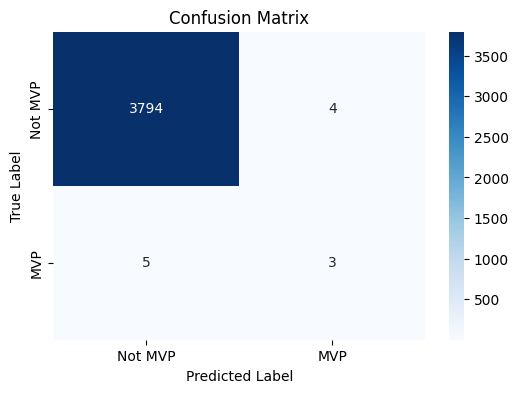

In [12]:
best_xgb = xgb_search.best_estimator_
xgb_pred = best_xgb.predict(X_test)
xgb_proba = best_xgb.predict_proba(X_test)[:, 1]

print("Test set performance:")
print(classification_report(y_test, xgb_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, xgb_pred))
plot_confusion_matrix(y_test, xgb_pred)

In [138]:
xgb_missed_idx = (xgb_pred != y_test) & (y_test == 1)
xgb_missed_mvps = df.iloc[y_test[xgb_missed_idx].index]
print("\nMissed MVPs by XGBoost:", xgb_missed_mvps[['player', 'season']])


Missed MVPs by XGBoost:                player  season
10100     Karl Malone    1999
11227      Larry Bird    1984
10534    Kevin Durant    2014
4358   David Robinson    1995
16695   Stephen Curry    2016


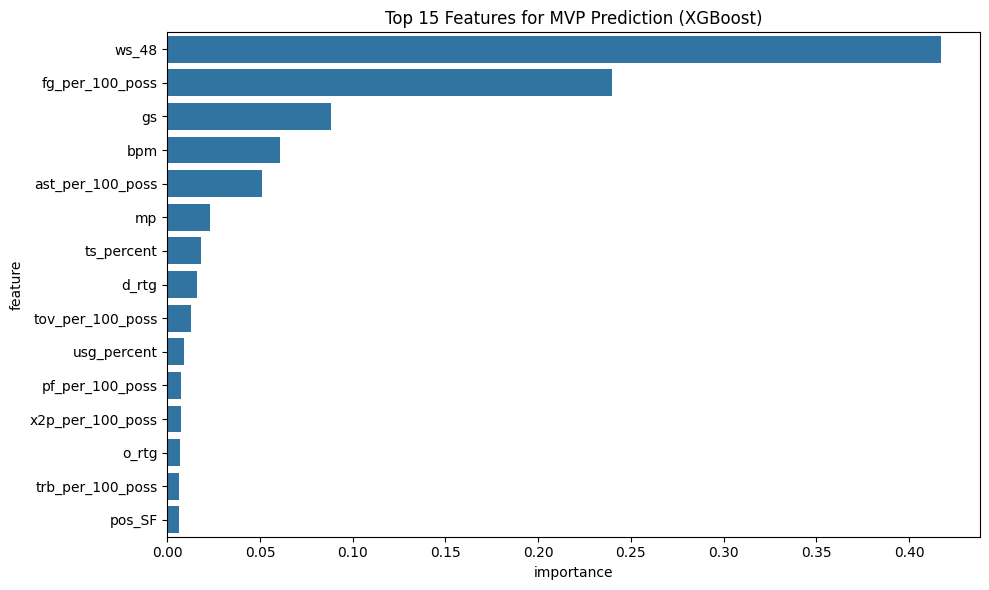

In [ ]:
feature_names = (
    pre.named_transformers_['num'].get_feature_names_out().tolist() +
    pre.named_transformers_['cat'].get_feature_names_out().tolist()
)

importances = best_xgb.named_steps['xgb'].feature_importances_
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp)
plt.title('Top 15 Features for MVP Prediction (XGBoost)')
plt.tight_layout()
plt.show()

The XGBoost model places even greater emphasis on ws_48 and fg_per_100_poss compared to Random Forest, indicating that these advanced and volume-based metrics are the most predictive for MVP selection in our dataset. While both models agree on the importance of advanced stats and playing time, XGBoost is more selective, which may improve performance but also risks over-reliance on a few features.

In [141]:
joblib.dump(best_xgb, 'models/xgb_mvp_model.pkl')
print("Model saved to 'models/xgb_mvp_model.pkl'")

Model saved to 'models/xgb_mvp_model.pkl'


To improve prediction accuracy, I will try a two-stage modeling approach. In the first stage, a model is used to identify MVP candidates from all players in a season. In the second stage, a separate model is applied only to these candidates to predict the final MVP winner. This strategy helps the model focus on distinguishing the true MVP among the top-performing players, rather than from the entire player pool.

In [142]:
mvp_voting = load_dataset('Player Award Shares.csv')
mvp_voting = mvp_voting[(mvp_voting['season'] > 1982) & 
                        (mvp_voting['award'] == 'nba mvp')]

Dataset loaded from datasets/Player Award Shares.csv


In [ ]:
# In award dataset, we have only candidates and winners
mvp_voting['is_candidate'] = 1
df = df.merge(
    mvp_voting[['player', 'season', 'is_candidate']],
    on=['player', 'season'],
    how='left'
)
# I fill NaN values with 0 for non-candidates
df['is_candidate'] = df['is_candidate'].fillna(0).astype(int)

In [160]:
save_dataset(df, 'combined_stats_final_with_candidates.csv')

Dataset saved to datasets/combined_stats_final_with_candidates.csv


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['is_mvp', 'is_candidate', 'player', 'season']),
    df['is_candidate'],
    test_size=0.2,
    random_state=39,
    stratify=df['is_candidate']
)

In [54]:
stage1_pre = build_preprocessor(X_train, ['pos'])
stage1_model = XGBClassifier(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    # this parameter is important for imbalanced datasets
    # since we have many more non-candidates than candidates
    # we set scale_pos_weight to higher value than default which is 1
    scale_pos_weight=20,
    random_state=39
)

stage1_pipe = Pipeline([
    ('pre', stage1_pre),
    ('model', stage1_model)
])

stage1_pipe.fit(X_train, y_train)
print("Stage 1 CV F1:", cross_val_score(
    stage1_pipe, X_train, y_train, cv=5, scoring='f1').mean())

Stage 1 CV F1: 0.7226299876775788


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3675
           1       0.63      0.77      0.69       131

    accuracy                           0.98      3806
   macro avg       0.81      0.88      0.84      3806
weighted avg       0.98      0.98      0.98      3806

Confusion Matrix:
[[3615   60]
 [  30  101]]


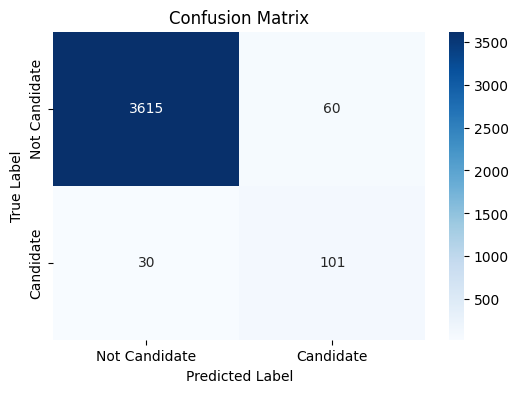

In [55]:
y_pred = stage1_pipe.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
plot_confusion_matrix(y_test, y_pred, labels=['Not Candidate', 'Candidate'])

For the first stage, we trained an XGBoost classifier to identify MVP candidates. We addressed class imbalance with the scale_pos_weight parameter. The model was evaluated using 5-fold cross-validation, and the mean F1 score indicates strong performance in distinguishing candidates from the general player pool. This step is essential for narrowing down the set of players for the final MVP prediction.

In [73]:
# Initializes a new column in our main dataframe 
# to store the probability that each player is an MVP candidate.
df['candidate_prob'] = np.nan
X_all = df.drop(columns=['is_mvp', 'is_candidate', 'candidate_prob', 'player', 'season'])
# Uses our trained Stage 1 model to predict 
# the probability that each player is an MVP candidate, 
# and stores these probabilities in the candidate_prob column.
df.loc[:, 'candidate_prob'] = stage1_pipe.predict_proba(X_all)[:, 1]

In [57]:
# We only get candidates for the second stage
candidates_df = df[df['is_candidate'] == 1].copy()
print(f"Training Stage 2 on {len(candidates_df)} candidates")

Training Stage 2 on 654 candidates


In [58]:
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(
    candidates_df.drop(columns=['is_mvp', 'is_candidate', 'candidate_prob', 'player', 'season']),
    candidates_df['is_mvp'],
    test_size=0.2, 
    random_state=39,
    stratify=candidates_df['is_mvp']
)


Stage 1 deals with a highly imbalanced dataset (few candidates, many non-candidates), so it uses a higher scale_pos_weight to help the model focus on the rare positive class. It also uses a higher learning rate and deeper trees to quickly learn broad patterns that separate candidates from the general player pool.

Stage 2 works only with MVP candidates, so the class imbalance is less severe (lower scale_pos_weight). The model uses more trees (n_estimators=300), shallower trees (max_depth=5), and a lower learning rate (0.05) to carefully distinguish the single MVP winner from other strong candidates, reducing the risk of overfitting on a smaller, more homogeneous dataset.

In [59]:
stage2_pre = build_preprocessor(X_train_s2, ['pos'])
stage2_model = XGBClassifier(
    # we put more trees for finer discrimination among candidates
    n_estimators=300, 
    # shallower trees to reduce overfitting since our pool is smaller
    max_depth=5, 
    # lower learning rate for more precise, gradual learning
    learning_rate=0.05, 
    # In here we set scale_pos_weight to a lower value than in stage 1
    # because we have only candidates in this stage, which are more balanced
    scale_pos_weight=10,
    random_state=39
)

stage2_pipe = Pipeline([
    ('pre', stage2_pre),
    ('model', stage2_model)
])

stage2_pipe.fit(X_train_s2, y_train_s2)
print("Stage 2 CV F1:", cross_val_score(
    stage2_pipe, X_train_s2, y_train_s2, cv=5, scoring='f1').mean())

Stage 2 CV F1: 0.4478542510121457


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       123
           1       0.40      0.50      0.44         8

    accuracy                           0.92       131
   macro avg       0.68      0.73      0.70       131
weighted avg       0.93      0.92      0.93       131

Confusion Matrix:
[[117   6]
 [  4   4]]


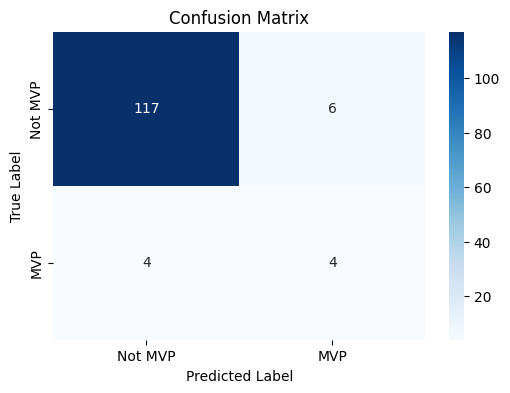

In [60]:
y_pred = stage2_pipe.predict(X_test_s2)
print(classification_report(y_test_s2, y_pred))
print(f"Confusion Matrix:\n{confusion_matrix(y_test_s2, y_pred)}")
plot_confusion_matrix(y_test_s2, y_pred)

Since Stage 2 only considers MVP candidates (who are all strong players), this is a challenging problem, distinguishing the single winner from a pool of top performers.
So I think this is actually a decent score.

In [159]:
joblib.dump(stage1_pipe, 'models/mvp_stage1_model.pkl')
joblib.dump(stage2_pipe, 'models/mvp_stage2_model.pkl')

['models/mvp_stage2_model.pkl']

In [61]:
test_season = 2014
if test_season in df['season'].unique():
    test_df = df[df['season'] == test_season].copy()
    predictions = predict_mvp(test_df, stage1_pipe, stage2_pipe)

    print("\nTop 5 MVP predictions for", test_season)
    print(predictions[['player', 'candidate_prob', 'mvp_prob']].head(5))
    
    actual_mvp = df[(df['season'] == test_season) & (df['is_mvp'] == 1)]['player'].values
    if len(actual_mvp) > 0:
        print(f"Actual MVP: {actual_mvp[0]}")
        print(f"Predicted correctly: {predictions.iloc[0]['player'] == actual_mvp[0]}")
else:
    print(f"Season {test_season} not found in dataset")


Top 5 MVP predictions for 2014
          player  candidate_prob  mvp_prob
0   Kevin Durant        0.999943  0.985223
1   LeBron James        0.999978  0.077548
2     Kevin Love        0.999723  0.052070
3  Stephen Curry        0.999921  0.013224
4     Chris Paul        0.998579  0.002250
Actual MVP: Kevin Durant
Predicted correctly: True


In [62]:
test_season = 2016
if test_season in df['season'].unique():
    test_df = df[df['season'] == test_season].copy()
    predictions = predict_mvp(test_df, stage1_pipe, stage2_pipe)

    print("\nTop 5 MVP predictions for", test_season)
    print(predictions[['player', 'candidate_prob', 'mvp_prob']].head(5))
    
    actual_mvp = df[(df['season'] == test_season) & (df['is_mvp'] == 1)]['player'].values
    if len(actual_mvp) > 0:
        print(f"Actual MVP: {actual_mvp[0]}")
        print(f"Predicted correctly: {predictions.iloc[0]['player'] == actual_mvp[0]}")
else:
    print(f"Season {test_season} not found in dataset")


Top 5 MVP predictions for 2016
              player  candidate_prob  mvp_prob
0      Stephen Curry        0.999814  0.987502
1       Kevin Durant        0.999960  0.068439
2  Russell Westbrook        0.999942  0.025122
3       LeBron James        0.999994  0.016793
4       James Harden        0.998972  0.004029
Actual MVP: Stephen Curry
Predicted correctly: True


Results are looking really great, let's see the scores


=== STAGE 1: CANDIDATE IDENTIFICATION ===
How well does our model identify players who received MVP votes?
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3675
           1       0.63      0.77      0.69       131

    accuracy                           0.98      3806
   macro avg       0.81      0.88      0.84      3806
weighted avg       0.98      0.98      0.98      3806

Confusion Matrix:
[[3615   60]
 [  30  101]]


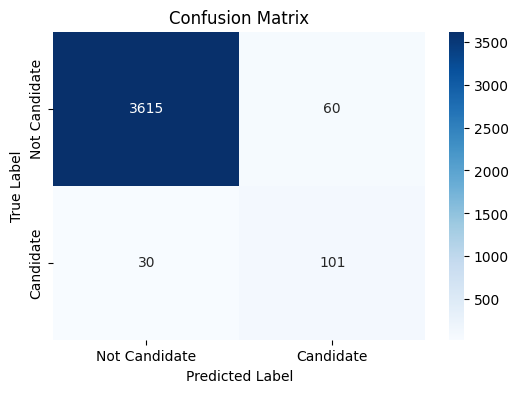

In [71]:
stage1_y_pred = stage1_pipe.predict(X_test)
print("\n=== STAGE 1: CANDIDATE IDENTIFICATION ===")
print("How well does our model identify players who received MVP votes?")
print(classification_report(y_test, stage1_y_pred))
print(f"Confusion Matrix:\n{confusion_matrix(y_test, stage1_y_pred)}")
plot_confusion_matrix(y_test, stage1_y_pred, labels=['Not Candidate', 'Candidate'])

I think we have decent scores for stage 1 model. 0.69 F1-score is not bad at all for given the class imbalance.

However, 30 real candidates were missed (false negatives), which could limit Stage 2’s ability to select the true MVP in those cases.


=== STAGE 2: MVP WINNER SELECTION ===
Among actual MVP candidates, how well does our model identify the winner?
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       118
           1       0.86      0.92      0.89        13

    accuracy                           0.98       131
   macro avg       0.92      0.95      0.94       131
weighted avg       0.98      0.98      0.98       131

Confusion Matrix:
[[116   2]
 [  1  12]]


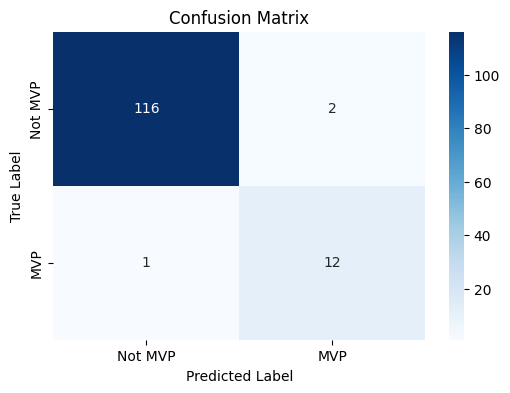

In [74]:
test_candidates = df.loc[y_test.index[y_test == 1]]
if len(test_candidates) > 0:
    X_test_cand = test_candidates.drop(columns=['is_mvp', 'is_candidate', 'candidate_prob', 'player', 'season'])
    y_test_cand = test_candidates['is_mvp']
    
    stage2_y_pred = stage2_pipe.predict(X_test_cand)
    print("\n=== STAGE 2: MVP WINNER SELECTION ===")
    print("Among actual MVP candidates, how well does our model identify the winner?")
    print(classification_report(y_test_cand, stage2_y_pred))
    print(f"Confusion Matrix:\n{confusion_matrix(y_test_cand, stage2_y_pred)}")
    plot_confusion_matrix(y_test_cand, stage2_y_pred, labels=['Not MVP', 'MVP'])
else:
    print("\nNo MVP candidates found in test set to evaluate Stage 2.")

High recall (0.92) means the model almost always finds the true MVP among the candidates.

High precision (0.86) means that most players predicted as MVP are actually the true winner.

Only 1 MVP winner was missed in the test set, showing strong reliability.

There are still a few false positives (2 cases), where a non-winner was predicted as MVP, but this is a minor issue given the difficulty of the task.

In [ ]:
print("\n=== FULL PIPELINE EVALUATION ===")
test_seasons = sorted(df.loc[y_test.index, 'season'].unique())
print(f"Evaluating on {len(test_seasons)} unique seasons in test set")

correct_predictions = 0
top3_correct = 0
top5_correct = 0
ranks = []
missed_mvp_seasons = []
all_season_predictions = {}

for season in test_seasons:
    test_season_df = df[df['season'] == season].copy()
    actual_mvp_df = test_season_df[test_season_df['is_mvp'] == 1]
    
    if not actual_mvp_df.empty:
        actual_mvp_player_name = actual_mvp_df['player'].values[0]
        predictions = predict_mvp(test_season_df, stage1_pipe, stage2_pipe)
        all_season_predictions[season] = predictions
        
        if not predictions.empty:
            if predictions.iloc[0]['player'] == actual_mvp_player_name:
                correct_predictions += 1
            else:
                missed_mvp_seasons.append(season)

            top3 = predictions.head(3)['player'].values
            if actual_mvp_player_name in top3:
                top3_correct += 1

            top5 = predictions.head(5)['player'].values
            if actual_mvp_player_name in top5:
                top5_correct += 1
                
            try:
                mvp_rank = predictions[predictions['player'] == actual_mvp_player_name].index[0] + 1
            except IndexError:
                mvp_rank = float('inf')
            ranks.append(mvp_rank)
            
            print(f"\nSeason {season}:")
            print(f"  Actual MVP: {actual_mvp_player_name}")
            print(f"  Predicted MVP: {predictions.iloc[0]['player']}")
            print(f"  Actual MVP rank in predictions: {mvp_rank}")
            print(f"  Top 3 predictions: {', '.join(top3)}")
        else:
            print(f"\nSeason {season}:")
            print(f"  Actual MVP: {actual_mvp_player_name}")
            print(f"  Predicted MVP: No prediction made")
            ranks.append(float('inf'))
            missed_mvp_seasons.append(season)
    else:
        # No actual MVP in this season's test data slice, can't evaluate Top-N for it
        print(f"\nSeason {season}: No actual MVP found in test data to evaluate against.")

num_seasons_with_mvp = len([s for s in test_seasons if not df[(df['season'] == s) & (df['is_mvp'] == 1)].empty])
print("\nOverall Metrics:")
if num_seasons_with_mvp > 0 :
    print(f"  Total Seasons Evaluated (with an actual MVP): {num_seasons_with_mvp}")
    print(f"  Top-1 Accuracy: {correct_predictions/num_seasons_with_mvp:.2f} ({correct_predictions}/{num_seasons_with_mvp})")
    print(f"  Top-3 Accuracy: {top3_correct/num_seasons_with_mvp:.2f} ({top3_correct}/{num_seasons_with_mvp})")
    print(f"  Top-5 Accuracy: {top5_correct/num_seasons_with_mvp:.2f} ({top5_correct}/{num_seasons_with_mvp})")
else:
    print("  No seasons with an actual MVP found in the test set to calculate accuracy metrics.")

if ranks:
    valid_ranks = [r for r in ranks if r != float('inf')]
    print(f"  Mean Rank of Actual MVP (overall): {sum(ranks)/len(ranks) if ranks else 'N/A':.2f}")
    if valid_ranks:
        print(f"  Mean Rank when MVP is found in predictions: {sum(valid_ranks)/len(valid_ranks):.2f}")
    if len(valid_ranks) < len(ranks):
        print(f"  Number of MVPs not found in prediction list: {len(ranks) - len(valid_ranks)}")

print("\n=== ANALYSIS OF MISSED MVP PREDICTIONS ===")
unique_missed_mvp_seasons = sorted(list(set(missed_mvp_seasons)))
if not unique_missed_mvp_seasons:
    print("No missed MVP predictions in this test set!")
else:
    print(f"Analyzing {len(unique_missed_mvp_seasons)} uniquely missed MVP predictions")
    
    stat_cols = ['g', 'mp', 'ws_48', 'bpm', 'ts_percent', 'usg_percent', 
                 'fg_per_100_poss', 'ast_per_100_poss', 'trb_per_100_poss']
    
    for season in unique_missed_mvp_seasons:
        test_season_df = df[df['season'] == season].copy()
        actual_mvp_df = test_season_df[test_season_df['is_mvp'] == 1]
        
        if actual_mvp_df.empty:
            print(f"\nSeason {season}: Actual MVP data missing, cannot perform detailed comparison.")
            continue
        actual_mvp_player_name = actual_mvp_df['player'].values[0]

        if season in all_season_predictions:
            predictions = all_season_predictions[season]
        else:
            print(f"Warning: Predictions for missed season {season} not found in storage. Recalculating.")
            predictions = predict_mvp(test_season_df, stage1_pipe, stage2_pipe)
        
        if predictions.empty:
            print(f"\nSeason {season} Comparison:")
            print(f"  Actual MVP: {actual_mvp_player_name}")
            print(f"  Predicted MVP: No prediction was made by the model.")
            continue
            
        predicted_mvp_name = predictions.iloc[0]['player']
        predicted_mvp_stats_df = test_season_df[test_season_df['player'] == predicted_mvp_name]
        
        if predicted_mvp_stats_df.empty:
            print(f"\nSeason {season} Comparison:")
            print(f"  Actual MVP: {actual_mvp_player_name}")
            print(f"  Predicted MVP: {predicted_mvp_name} (Stats not found in season data for comparison)")
            continue
        
        print(f"\nSeason {season} Comparison:")
        print(f"  Actual MVP: {actual_mvp_player_name} vs Predicted MVP: {predicted_mvp_name}")
        
        comparison = pd.DataFrame({
            'Stat': stat_cols,
            'Actual MVP': actual_mvp_df[stat_cols].values[0],
            'Predicted MVP': predicted_mvp_stats_df[stat_cols].values[0]
        })
        
        comparison['% Difference'] = ((comparison['Predicted MVP'] - comparison['Actual MVP']) / 
                                     comparison['Actual MVP'].replace(0, np.nan) * 100).round(1) # Avoid division by zero
        
        print("\n  Stat Comparison:")
        print("  " + "-" * 65)
        print(f"  {'Stat':<15} {'Actual MVP':<12} {'Predicted MVP':<12} {'% Difference':<12}")
        print("  " + "-" * 65)
        for _, row in comparison.iterrows():
            print(f"  {row['Stat']:<15} {row['Actual MVP']:<12.2f} {row['Predicted MVP']:<12.2f} {row['% Difference']:+<12.1f}")
        
        predicted_mvp_prob = predictions.iloc[0]['mvp_prob']
        actual_mvp_row_in_predictions = predictions[predictions['player'] == actual_mvp_player_name]
        
        print("\n  Model Confidence:")
        print(f"  Predicted MVP ({predicted_mvp_name}) confidence: {predicted_mvp_prob:.4f}")
        if not actual_mvp_row_in_predictions.empty:
            actual_mvp_confidence = actual_mvp_row_in_predictions['mvp_prob'].values[0]
            print(f"  Actual MVP ({actual_mvp_player_name}) confidence in prediction list: {actual_mvp_confidence:.4f}")
        else:
            print(f"  Actual MVP ({actual_mvp_player_name}) was not in the top candidates returned by predict_mvp for this season.")


=== FULL PIPELINE EVALUATION ===
Evaluating on 43 unique seasons in test set

Season 1983:
  Actual MVP: Moses Malone
  Predicted MVP: Larry Bird
  Actual MVP rank in predictions: 2
  Top 3 predictions: Larry Bird, Moses Malone, Gus Williams

Season 1984:
  Actual MVP: Larry Bird
  Predicted MVP: Larry Bird
  Actual MVP rank in predictions: 1
  Top 3 predictions: Larry Bird, Adrian Dantley, Rickey Green

Season 1985:
  Actual MVP: Larry Bird
  Predicted MVP: Larry Bird
  Actual MVP rank in predictions: 1
  Top 3 predictions: Larry Bird, Magic Johnson, Michael Jordan

Season 1986:
  Actual MVP: Larry Bird
  Predicted MVP: Larry Bird
  Actual MVP rank in predictions: 1
  Top 3 predictions: Larry Bird, Magic Johnson, Alex English

Season 1987:
  Actual MVP: Magic Johnson
  Predicted MVP: Magic Johnson
  Actual MVP rank in predictions: 1
  Top 3 predictions: Magic Johnson, Larry Bird, Michael Jordan

Season 1988:
  Actual MVP: Michael Jordan
  Predicted MVP: Michael Jordan
  Actual MVP ra